In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.anova import AnovaRM
import pylab
import datetime

In [2]:
ndvi = pd.read_csv('../Data/NDVI/NDVIM42021Buf2.csv', index_col=0)
doy = [pd.to_datetime(x) for x in ndvi.columns]
doy = [(x - datetime.datetime(2021, 1, 1)).days for x in doy]
ndvi.columns = doy
ndvi['Plot'] = ndvi.index
print(ndvi.shape)
ndvi.head()

(36, 5)


,195,202,209,251,Plot
Field ID,,,,,
1,0.705796,0.745421,0.814882,0.756117,1
2,0.646746,0.709840,0.797777,0.739282,2
3,0.702501,0.770107,0.842404,0.817051,3
4,0.704468,0.800970,0.868706,0.841784,4
5,0.688989,0.792179,0.863945,0.802904,5


In [3]:
plot_key = pd.read_excel('../Data/ID and Plots.xlsx', engine='openpyxl')
plot_key = plot_key[plot_key['Plot'].str.contains('N')].reset_index().drop('index', axis = 1)
print(plot_key.shape)
plot_key.index = [x[:-1] for x in plot_key['Plot']]
plot_key['Plot'] = [int(x[:-1]) for x in plot_key['Plot']]
plot_key.head()

(36, 7)


,ID,Plot,Nitrogen,Water,Block,Water rate (%ET),Nrate (llbs/acre)
1,114,1,4,1,1,100,155
2,111,2,1,1,1,100,20
3,115,3,5,1,1,100,200
4,113,4,3,1,1,100,110
5,112,5,2,1,1,100,65


In [4]:
full_df = pd.merge(ndvi, plot_key, on = 'Plot')
full_df_complex = full_df.drop(['ID','Block','Water','Nitrogen'], axis =1)
full_df_simple = full_df.drop(['ID','Block','Water rate (%ET)','Nrate (llbs/acre)'], axis =1)
full_df_simple.head()

,195,202,209,251,Plot,Nitrogen,Water
0,0.705796,0.745421,0.814882,0.756117,1,4,1
1,0.646746,0.709840,0.797777,0.739282,2,1,1
2,0.702501,0.770107,0.842404,0.817051,3,5,1
3,0.704468,0.800970,0.868706,0.841784,4,3,1
4,0.688989,0.792179,0.863945,0.802904,5,2,1


In [5]:
full_df_melted = full_df_simple.melt(value_vars = [195,202,209,251], id_vars = ['Plot','Water','Nitrogen'])
full_df_melted_complex = full_df_complex.melt(value_vars = [195,202,209,251], id_vars = ['Plot','Water rate (%ET)','Nrate (llbs/acre)'])
full_df_melted.columns = ['Plot','Water','Nitrogen','DOY','NDVI']
full_df_melted_complex.columns = ['Plot','Water rate (%ET)','Nrate (llbs/acre)','DOY','NDVI']
full_df_melted['NDVI_log'] = np.log(full_df_melted['NDVI'])
full_df_melted.head()

,Plot,Water,Nitrogen,DOY,NDVI,NDVI_log
0,1,1,4,195,0.705796,-0.348428
1,2,1,1,195,0.646746,-0.435801
2,3,1,5,195,0.702501,-0.353109
3,4,1,3,195,0.704468,-0.350313
4,5,1,2,195,0.688989,-0.372530


In [6]:
# normality test
# Plot residuals
stat, p = shapiro(full_df_melted['NDVI'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.967, p=0.002
Sample does not look Gaussian (reject H0)


<AxesSubplot:xlabel='NDVI', ylabel='Count'>

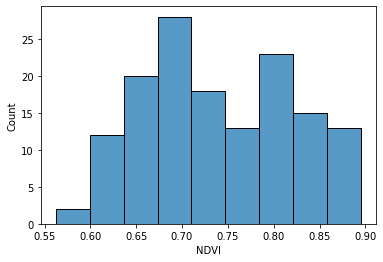

In [7]:
sns.histplot(full_df_melted['NDVI'])

In [8]:
model = AnovaRM(full_df_melted, 'NDVI', 'DOY', within = ['Nitrogen','Water'], aggregate_func='mean')
results = model.fit()
print(results)

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
Nitrogen       85.6669 5.0000 15.0000 0.0000
Water          19.0278 1.0000  3.0000 0.0223
Nitrogen:Water  5.9242 5.0000 15.0000 0.0032



In [9]:
full_df_melted_complex.head()

,Plot,Water rate (%ET),Nrate (llbs/acre),DOY,NDVI
0,1,100,155,195,0.705796
1,2,100,20,195,0.646746
2,3,100,200,195,0.702501
3,4,100,110,195,0.704468
4,5,100,65,195,0.688989


<AxesSubplot:xlabel='Nrate (llbs/acre)', ylabel='NDVI'>

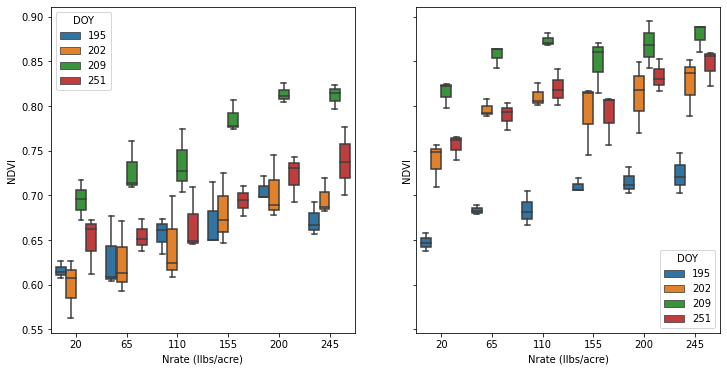

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
sns.boxplot(y = 'NDVI', x = 'Nrate (llbs/acre)', hue = 'DOY', 
            data = full_df_melted_complex[full_df_melted_complex['Water rate (%ET)'] == 70], ax = axes[0])
sns.boxplot(y = 'NDVI', x = 'Nrate (llbs/acre)', hue = 'DOY', 
            data = full_df_melted_complex[full_df_melted_complex['Water rate (%ET)'] == 100], ax = axes[1])